# EFC 1 - Regressão linear para a predição de manchas solares
    Utilizando os dados fornecidos sobre manchas solares de 1749 até 2019

In [1]:
import pandas as pd
import math
import numpy as np
from numpy import genfromtxt
from numpy import linalg
import matplotlib.pyplot as plt 
from scipy.linalg import toeplitz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

In [2]:
manchas = genfromtxt('monthly-sunspots.csv', delimiter=',')

In [3]:
manchas = np.delete(manchas,np.s_[0:2],axis=1)
manchas = np.delete(manchas,0,axis=0)

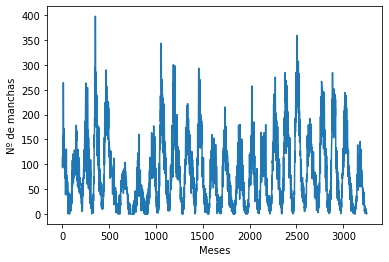

In [4]:
plt.plot(manchas)
#plt.title("Manchas solares ao longo dos meses")
plt.xlabel("Meses")
plt.ylabel("Nº de manchas")
plt.show()

In [5]:
K = 24
X = toeplitz(manchas[::-1]) # matriz de entrada
y = manchas[K:] # vetor de saída
N = len(y)
print(X)
print(y)

[[  1.6   0.5   0.4 ... 116.7 104.3  96.7]
 [  0.5   1.6   0.5 ...  92.8 116.7 104.3]
 [  0.4   0.5   1.6 ... 141.7  92.8 116.7]
 ...
 [116.7  92.8 141.7 ...   1.6   0.5   0.4]
 [104.3 116.7  92.8 ...   0.5   1.6   0.5]
 [ 96.7 104.3 116.7 ...   0.4   0.5   1.6]]
[[116.7]
 [ 72.5]
 [ 75.5]
 ...
 [  0.4]
 [  0.5]
 [  1.6]]


In [6]:
XL = X[:,:K]
XL = XL[::-1]
XL = XL[:-K]
XL

array([[ 96.7, 104.3, 116.7, ..., 109.5, 105.5, 125.7],
       [104.3, 116.7,  92.8, ..., 105.5, 125.7, 116.7],
       [116.7,  92.8, 141.7, ..., 125.7, 116.7,  72.5],
       ...,
       [ 13.2,   5.7,   8.2, ...,   0.9,   0.5,   1.1],
       [  5.7,   8.2,   6.8, ...,   0.5,   1.1,   0.4],
       [  8.2,   6.8,  10.7, ...,   1.1,   0.4,   0.5]])

In [7]:
Xtest = XL[-120:,:]
ytest = y[-120:,:]
Xtrain = XL[:-120,:]
ytrain = y[:-120,:]

In [8]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

# Parte I

In [9]:
# Regressão linear sem a implementação de K-Fold
reg = LinearRegression(fit_intercept=True).fit(Xtreino, ytreino)
est = reg.predict(Xtreino)
err = rmse(est,ytreino)
print("Root Mean Square Error:",err)
plt.plot(reg.predict(Xtreino))

NameError: name 'Xtreino' is not defined

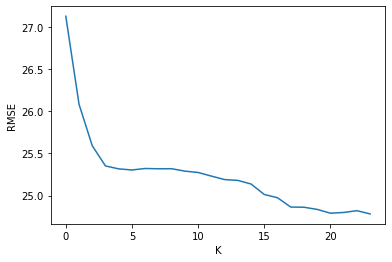

24.78302968923615
24


In [10]:
n_splits_kfold = 4
kf = KFold(n_splits = n_splits_kfold)

rmse_vec = np.zeros(K)
for j in range(K,0,-1):
    Xtrain_subset = Xtrain[:,j-1:]
    
    rmse_acc = 0 

    for train_index, test_index in kf.split(Xtrain_subset):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train_kfold, X_test_kfold = Xtrain_subset[train_index], Xtrain_subset[test_index]
        y_train_kfold, y_test_kfold = ytrain[train_index], ytrain[test_index]
        
        reg = LinearRegression(fit_intercept=True).fit(X_train_kfold, y_train_kfold)
        ypred_kfold = reg.predict(X_test_kfold)
        rmse_acc += rmse(y_test_kfold, ypred_kfold)
    
    rmse_vec[K-j] = rmse_acc/n_splits_kfold
    #print(rmse_acc, rmse_vec[K-k])

plt.plot(rmse_vec)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()
best_k = rmse_vec.argmin() + 1
print(min(rmse_vec))
print(best_k)

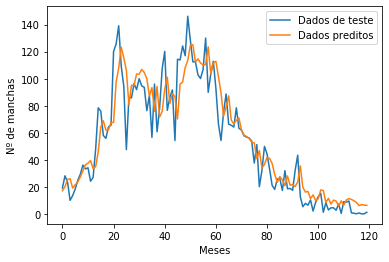

In [11]:
Xtrain_final = Xtrain[:,-best_k:]
Xtest_final = Xtest[:,-best_k:]
reg_final = LinearRegression(fit_intercept=True).fit(Xtrain_final, ytrain)
ypred_test = reg_final.predict(Xtest_final)
rmse_final = rmse(ytest, ypred_test)
rmse_final
plt.plot(ytest,label = 'Dados de teste')
plt.plot(ypred_test,label = 'Dados preditos')
plt.xlabel('Meses')
plt.ylabel('Nº de manchas')
#plt.title("Comparação entre dados de teste e previsões para estes dados")
plt.legend()

# Parte II

In [12]:
# inicialização das variáveis
K2 = 8
Xtrain2 = Xtrain[:,-K2:]
Xtest2 = Xtest[:,-K2:]

print(Xtrain2.shape)
print(Xtest2.shape)

(3108, 8)
(120, 8)


In [13]:
# normalização dos dados
mean_norm = Xtrain2.mean()
std_norm = Xtrain2.std()
nstd = 4

Xtrain2_norm = (Xtrain2 - mean_norm)/(nstd*std_norm)
Xtest2_norm = (Xtest2 - mean_norm)/(nstd*std_norm)
ytrain2_norm = (ytrain - mean_norm)/(nstd*std_norm)
ytest2_norm = (ytest - mean_norm)/(nstd*std_norm)

(array([1056.,  693.,  527.,  355.,  250.,  139.,   64.,   19.,    3.,
           2.]),
 array([-0.30276605, -0.1573585 , -0.01195096,  0.13345659,  0.27886413,
         0.42427168,  0.56967922,  0.71508677,  0.86049431,  1.00590186,
         1.1513094 ]),
 <a list of 10 Patch objects>)

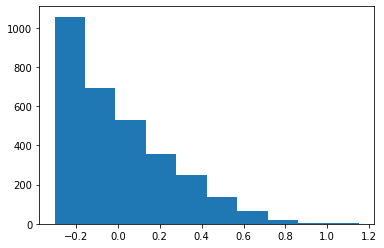

In [14]:
plt.hist(Xtrain2_norm[:,0])

In [15]:
n_splits_kfold2 = 4
kf2 = KFold(n_splits = n_splits_kfold2)
lambvec = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
Tvec = np.linspace(1,100,100)
result = np.zeros([len(Tvec),len(lambvec)])

for t in range(len(Tvec)):

    for lambridge in range(len(lambvec)):
        w = np.random.rand(K2,t+1)
        wXtrainL = np.tanh((w.T@Xtrain2_norm.T).T)

        rmseT = 0
        
        for train_index, test_index in kf2.split(Xtrain2_norm):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train_kfold2, X_test_kfold2 = wXtrainL[train_index], wXtrainL[test_index]
            y_train_kfold2, y_test_kfold2 = ytrain2_norm[train_index], ytrain2_norm[test_index]
            
            reg2 = Ridge(alpha = lambvec[lambridge],fit_intercept=True).fit(X_train_kfold2, y_train_kfold2)
            y_pred_kfold2 = reg2.predict(X_test_kfold2)

            y_test_kfold2 = y_test_kfold2*nstd*std_norm + mean_norm
            y_pred_kfold2 = y_pred_kfold2*nstd*std_norm + mean_norm

            rmseT += rmse(y_test_kfold2, y_pred_kfold2)
        result[t,lambridge] = rmseT/n_splits_kfold2
        print(lambvec[lambridge],t,result[t,lambridge])

0.001 0 34.13135148828897
0.01 0 33.61863273024524
0.1 0 33.01014165487229
1.0 0 34.78614314476437
10.0 0 33.40642948722042
100.0 0 33.0157864852697
1000.0 0 44.721883622092406
0.001 1 32.19123923964796
0.01 1 32.9113688512283
0.1 1 31.243937526054737
1.0 1 34.07966931731879
10.0 1 30.650990647109875
100.0 1 33.720315480447
1000.0 1 39.69095692368119
0.001 2 30.86557255771558
0.01 2 30.55774773920395
0.1 2 30.16410755267205
1.0 2 27.783965068520928
10.0 2 31.124936772380146
100.0 2 32.79302791429143
1000.0 2 36.400259093770366
0.001 3 30.39450444430418
0.01 3 31.5279187100069
0.1 3 30.703950642283928
1.0 3 29.67802968173536
10.0 3 29.431837514418397
100.0 3 32.384909566506124
1000.0 3 34.4612631226118
0.001 4 29.271999350362947
0.01 4 28.781861642752055
0.1 4 30.122302978403503
1.0 4 28.26365631134117
10.0 4 28.344697362355923
100.0 4 32.39778398067619
1000.0 4 34.55031645667637
0.001 5 27.60985568876574
0.01 5 27.003923548857973
0.1 5 26.856166576190027
1.0 5 28.54064453858982
10.0 5 

1000.0 44 32.11551286904091
0.001 45 25.71601473228103
0.01 45 25.640898874468146
0.1 45 25.799468445701216
1.0 45 26.088735257270713
10.0 45 27.17042669027222
100.0 45 29.04240930974266
1000.0 45 31.610247289435645
0.001 46 25.936529280393117
0.01 46 25.57611815517716
0.1 46 25.62704210118047
1.0 46 26.089949338881475
10.0 46 27.063326511302183
100.0 46 29.534525454010033
1000.0 46 31.708602669541783
0.001 47 25.67322722020576
0.01 47 25.641330467357133
0.1 47 25.625377010908387
1.0 47 25.832093676798305
10.0 47 26.99387394888867
100.0 47 29.597720625901516
1000.0 47 31.673707890746115
0.001 48 25.718620567101578
0.01 48 25.659099469881642
0.1 48 25.72719730816168
1.0 48 26.304940055329414
10.0 48 26.77125126526819
100.0 48 29.45917065250044
1000.0 48 32.10474757820659
0.001 49 25.809130975864456
0.01 49 25.708327984456574
0.1 49 25.90000529524144
1.0 49 25.759423992135602
10.0 49 26.96300860461671
100.0 49 29.257385711418536
1000.0 49 31.651680864724263
0.001 50 25.775125573442818
0.

1000.0 88 31.430227074234253
0.001 89 25.802039222363604
0.01 89 25.697217396781475
0.1 89 25.619747063284485
1.0 89 25.95706481876652
10.0 89 26.503847625099855
100.0 89 28.312650398952076
1000.0 89 31.113559315255408
0.001 90 25.910582923528874
0.01 90 25.621210838150123
0.1 90 25.620167020676952
1.0 90 25.804385298052193
10.0 90 26.52564578884687
100.0 90 28.239622598552693
1000.0 90 31.290368860047725
0.001 91 25.87569366900714
0.01 91 25.730319266637263
0.1 91 25.6340218634139
1.0 91 25.82819643728008
10.0 91 26.535482749177053
100.0 91 27.55451758977148
1000.0 91 31.10471058595087
0.001 92 25.920121447691372
0.01 92 25.57074023507968
0.1 92 25.56865057665134
1.0 92 25.749480923826745
10.0 92 26.522564279818607
100.0 92 28.268888843306684
1000.0 92 31.13128095769769
0.001 93 25.899082804817596
0.01 93 25.623660872267745
0.1 93 25.63608331102091
1.0 93 25.991191748158336
10.0 93 26.49286687841684
100.0 93 27.953521056717697
1000.0 93 31.394393209879233
0.001 94 25.868868206902164
0

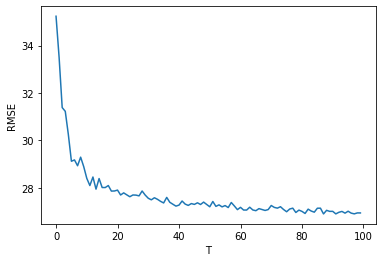

In [26]:
# gráfico do RMSE médio em função de T
rmse_mean = []
for i in range(len(Tvec)):
    rmse_mean.append(np.mean(result[i]))

plt.plot(range(len(rmse_mean)),rmse_mean)
plt.xlabel("T")
plt.ylabel("RMSE")
plt.show()

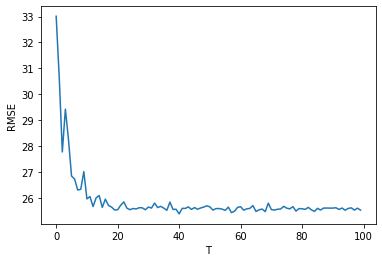

In [27]:
# gráfico do RMSE mínimo de cada T
rmse_min = []
for i in range(len(Tvec)):
    rmse_min.append(min(result[i]))

plt.plot(range(len(rmse_min)),rmse_min)
plt.xlabel("T")
plt.ylabel("RMSE")
plt.show()

In [17]:
# cálculo index_min
amin = np.where(result == np.amin(result))
index_min = list(zip(amin[0],amin[1]))
print(index_min)

[(40, 2)]


In [18]:
# valor de T e lambda
T = (index_min[0][0]) + 1
lamb = lambvec[index_min[0][1]]

print('Mínimo valor de RMSE:',min(rmse_min))
print('Valor de T estimado:',T)
print('Valor de lambda estimado:',lamb)

Mínimo valor de RMSE: 25.39621221863976
Valor de T estimado: 41
Valor de lambda estimado: 0.1


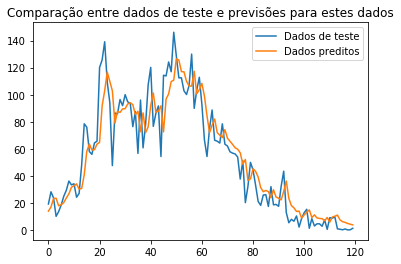

In [19]:
reg_final2 = Ridge(alpha = lambridge,fit_intercept=True).fit(Xtrain2_norm, ytrain2_norm)
ypred_test2_norm = reg_final2.predict(Xtest2_norm)
ypred_test2 = ypred_test2_norm*nstd*std_norm + mean_norm
rmse_final2 = rmse(ytest, ypred_test2)
rmse_final2
plt.plot(ytest,label = 'Dados de teste')
plt.plot(ypred_test2,label = 'Dados preditos')
plt.title("Comparação entre dados de teste e previsões para estes dados")
plt.legend()